<a href="https://colab.research.google.com/github/18521564/CS114.K21/blob/master/FaceDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
po_patches = faces.images
po_patches.shape

# lfw: label faced wild
#13233 face pic dùng cho training

(13233, 62, 47)

In [0]:
po_patches.shape
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
#lấy hình không chứa face từ skiamge

from skimage import data,transform,color,feature
import skimage.data

imgs_to_use = ['camera','text','coins','moon','chelsea','clock','page','immunohistochemistry','coffee','hubble_deep_field']

images = [color.rgb2gray(getattr(data,name)()) for name in imgs_to_use] 
#chuyển về hình đen trắng

In [0]:
from sklearn.feature_extraction.image import  PatchExtractor
#hàm giải nén
def extract_patches(img ,N,scale=1.0,patch_size=po_patches[0].shape):
  extracted_patch_size = \
  tuple((scale*np.array(patch_size)).astype(int))
  extractor  = PatchExtractor(patch_size=extracted_patch_size,max_patches=N,random_state=0)
  patches = extractor.transform(img[np.newaxis])
  if scale != 1:
    patches = np.array([transform.resize(patch,patch_size) for patch in patches])
  return patches

In [13]:
ne_patches = np.vstack([extract_patches(im,1000,scale) for im in images for scale in [0.5,1.0,2.0]])

ne_patches.shape

(30000, 62, 47)

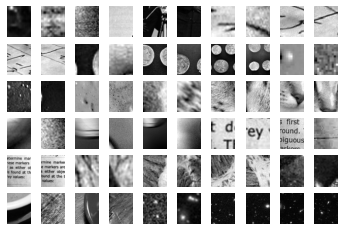

In [22]:
#in 60 hình theo khung 6*10
fix, ax = plt.subplots(6, 10)
for i,axi in enumerate(ax.flat):
  axi.imshow(ne_patches[500*i],cmap='gray')
  axi.axis('off')

In [24]:
#tạo X_train Y_train, X_train combine po và ne, Y_train theo X gồm 0 và 1
from itertools import chain
X_train = np.array([feature.hog(im) for im in chain(po_patches,ne_patches)])
Y_train = np.zeros(X_train.shape[0])
Y_train[:po_patches.shape[0]] = 1
X_train.shape

(43233, 1215)

In [27]:

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(),X_train,Y_train)



array([0.94784318, 0.97189777, 0.97340118, 0.97432339, 0.97374508])

In [30]:
#training bằng suport vector machine

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(),{'C':[1.0,2.0,4.0,8.0]})
grid.fit(X_train,Y_train)
grid.best_score_


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

0.9891981406266466

In [31]:
grid.best_params_

{'C': 1.0}

In [32]:
model = grid.best_estimator_
model.fit(X_train,Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

(-0.5, 139.5, 159.5, -0.5)

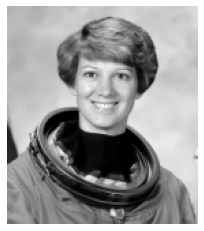

In [51]:
#xong bây giờ test bằng một hình bất kì

test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image,0.5)
test_image = test_image[:160,40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [38]:
#hàm chia ảnh
def sliding_window(img, patch_size=po_patches[0].shape,istep=2,jstep=2,scale=1.0):
  Ni, Nj = (int(scale*s) for s in patch_size)
  for i in range(0, img.shape[1] - Ni, istep):
    for j in range(0,img.shape[1]-Ni,jstep):
      patch = img[i:i+Ni,j:j+Nj]
      if scale!=1:
        patch = transform.resize(patch,patch_size)
      yield(i,j),patch
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches ])
patches_hog.shape

(1521, 1215)

In [39]:
label = model.predict(patches_hog)
label.sum()
# so điểm đúng trên ảnh

49.0

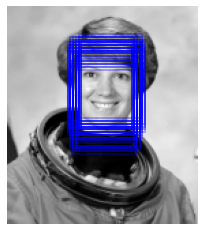

In [52]:
fig, ax = plt.subplots()
ax.imshow(test_image,cmap='gray')
ax.axis('off')

Ni,Nj = po_patches[0].shape
indices = np.array(indices)

for i,j in indices[label==1]:
  ax.add_patch(plt.Rectangle((j,i),Nj,Ni,alpha=0.3,lw=2,facecolor='none',edgecolor='blue'))
